# Submission 1
by Wilsion Lee

 ## Import Libraries

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

## Load Data

In [2]:
df_train = pd.read_csv("../../Data/Processed/train_cleaned.csv")
print(df_train.columns)
df_train.head()

Index(['id', 'log_price', 'accommodates', 'bathrooms', 'cancellation_policy',
       'cleaning_fee', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate',
       ...
       'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed', 'Boston', 'Chicago',
       'DC', 'LA', 'NYC', 'SF'],
      dtype='object', length=180)


,id,log_price,accommodates,bathrooms,cancellation_policy,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,...,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
0,13662370,3.806662,2,1.5,3,1,1368.0,1,1,100,...,0,0,0,1,0,1,0,0,0,0
1,4765892,4.941642,2,2.0,3,1,1200.0,1,1,100,...,0,0,0,1,0,0,0,1,0,0
2,21169968,4.941642,5,1.0,2,1,647.0,1,1,100,...,0,0,0,1,0,0,0,0,1,0
3,7939196,4.867534,6,1.0,3,1,2292.0,1,1,70,...,0,0,0,1,0,0,0,0,1,0
4,18161036,3.663562,2,1.0,1,1,734.0,1,1,100,...,0,0,0,1,0,0,0,1,0,0


In [3]:
df_test = pd.read_csv("../../Data/Processed/test_cleaned.csv")
print(df_test.columns)
df_test.head()

Index(['id', 'accommodates', 'bathrooms', 'cancellation_policy',
       'cleaning_fee', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       ...
       'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed', 'Boston', 'Chicago',
       'DC', 'LA', 'NYC', 'SF'],
      dtype='object', length=181)


c:\users\wilson lee\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,accommodates,bathrooms,cancellation_policy,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,...,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
0,986942,2,1.0,1,0,1306.0,1,1,0,1345.0,...,0,0,0,1,0,0,0,0,1,0
1,16436737,4,1.5,2,1,1525.0,1,1,100,1615.0,...,0,0,0,1,0,0,1,0,0,0
2,18209634,1,1.0,1,1,1019.0,1,1,100,1608.0,...,0,0,0,1,0,0,0,0,1,0
3,15027024,2,1.0,1,0,0.0,1,1,0,1418.0,...,0,0,0,1,0,0,0,0,1,0
4,18074243,6,1.0,3,1,1034.0,1,1,100,1095.0,...,0,0,0,1,0,0,0,0,1,0


## Model Testing function

In [4]:
def evaluation_chart(test, pred, title):
    plt.scatter(test, pred, alpha=0.3)
    plt.plot(range(0,5000000, 100), range(0,5000000, 100), '--r', alpha=0.3, label='Line1')
    plt.title(title)
    plt.xlabel('True Value')
    plt.ylabel('Predict Value')
    plt.xlim([0, 10])
    plt.ylim([0, 10])
    plt.show()

def model_training(model, X_train, y_train, X_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    return(y_pred)

def model_evaluation(title, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(title)
    print('MAE', round(mae, 2))
    print('RMSE', round(rmse, 2))
    evaluation_chart(y_test, y_pred, title)
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(10))
    return(mae, rmse)

def run_experiment(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    mae, rmse = model_evaluation(title, model, y_test, y_pred)
    return(mae, rmse)


## Model Definition

In [5]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10, random_state=5)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, random_state=5)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor()),
]

## Execution Function

In [6]:
def executetion(df_data, list_X_column, list_y_column):
    threshold = 0.8
    X = df_data[list_X_column]
    y = df_data[list_y_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

    print('X_train', X_train.shape)
    print('y_train', y_train.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)

    results = []
    for m in models:
        mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
        results.append([m[0], mae, rmse])
    
    return results


## Define Columns to Use

In [7]:
X_columns = ['accommodates','bathrooms','cancellation_policy','cleaning_fee',
 'first_review','host_has_profile_pic','host_identity_verified',
 'host_response_rate','host_since','instant_bookable','last_review',
 'latitude','longitude','neighbourhood','number_of_reviews',
 'review_scores_rating','thumbnail_url','bedrooms','beds',
 'Apartment','Bed & Breakfast','Boat','Boutique hotel','Bungalow','Cabin','Camper/RV', 'Condominium','House','Loft','Other',
 'Serviced apartment','Townhouse','guest_room','shared','unique','vaction_home','Entire home/apt','Private room','Shared room']

y_columns = ["log_price"]

## Run Model

X_train (40800, 39)
y_train (40800, 1)
X_test (10200, 39)
y_test (10200, 1)
LinearRegression
MAE 0.36
RMSE 0.48


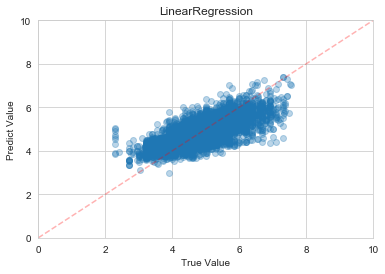

RandomForestRegressor10
MAE 0.3
RMSE 0.42


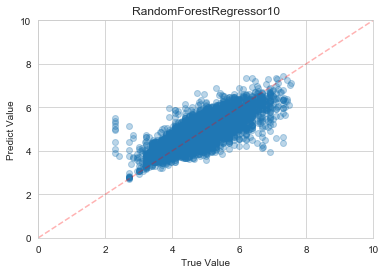

Feature Importance
                    0         1
36    Entire home/apt  0.358493
12          longitude  0.125928
1           bathrooms  0.119215
11           latitude  0.103067
8          host_since  0.048691
10        last_review  0.037699
0        accommodates  0.033276
17           bedrooms  0.028916
4        first_review  0.024498
14  number_of_reviews  0.017115
RandomForestRegressor100
MAE 0.29
RMSE 0.4


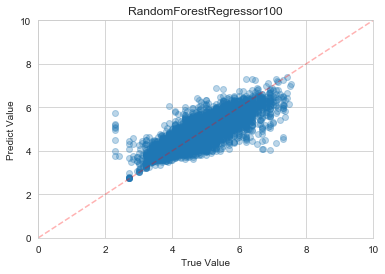

Feature Importance
                    0         1
36    Entire home/apt  0.359197
12          longitude  0.126583
1           bathrooms  0.119402
11           latitude  0.103353
8          host_since  0.047702
10        last_review  0.037955
0        accommodates  0.033145
17           bedrooms  0.027824
4        first_review  0.025238
14  number_of_reviews  0.017192
KNeighborsRegressor
MAE 0.57
RMSE 0.72


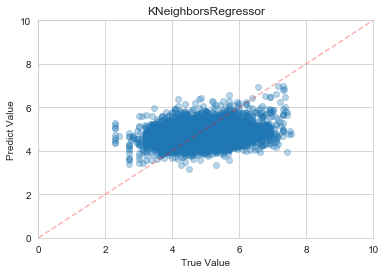

DecisionTreeRegressor
MAE 0.41
RMSE 0.56


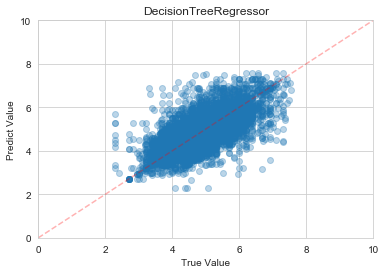

Feature Importance
                     0         1
36     Entire home/apt  0.358868
12           longitude  0.126247
1            bathrooms  0.122105
11            latitude  0.109234
8           host_since  0.048080
10         last_review  0.039185
0         accommodates  0.030724
17            bedrooms  0.025851
4         first_review  0.023939
7   host_response_rate  0.015905


In [8]:
results = executetion(df_train, X_columns, y_columns)

## Model performance

In [9]:
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

,model,mae,rmse
2,RandomForestRegressor100,0.288263,0.397843
1,RandomForestRegressor10,0.303304,0.415790
0,LinearRegression,0.363556,0.475502
4,DecisionTreeRegressor,0.406553,0.559031
3,KNeighborsRegressor,0.568316,0.723239


## Fit Test Data

In [10]:
print("Using Model {0}".format(models[2][0]))
X_test = df_test[X_columns]
y_pred = models[2][1].predict(X_test)

Using Model RandomForestRegressor100


## Prepare Data for Submission

In [11]:
df_test['log_price'] = y_pred
df_save = df_test[['id', 'log_price']]
df_save

,id,log_price
0,986942,4.281325
1,16436737,4.282817
2,18209634,3.890019
3,15027024,4.438498
4,18074243,5.026053
5,8446914,5.390552
6,19362916,4.044516
7,16116059,5.997956
8,20912583,5.265281
9,13573101,4.809242


## Save Data

In [12]:
df_save.to_csv("../../Data/Modeling/submission_01.csv", index=False)